  0%|                                                                                           | 0/300 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████| 300/300 [03:17<00:00,  1.52it/s, ELBO=-2.15e+09]


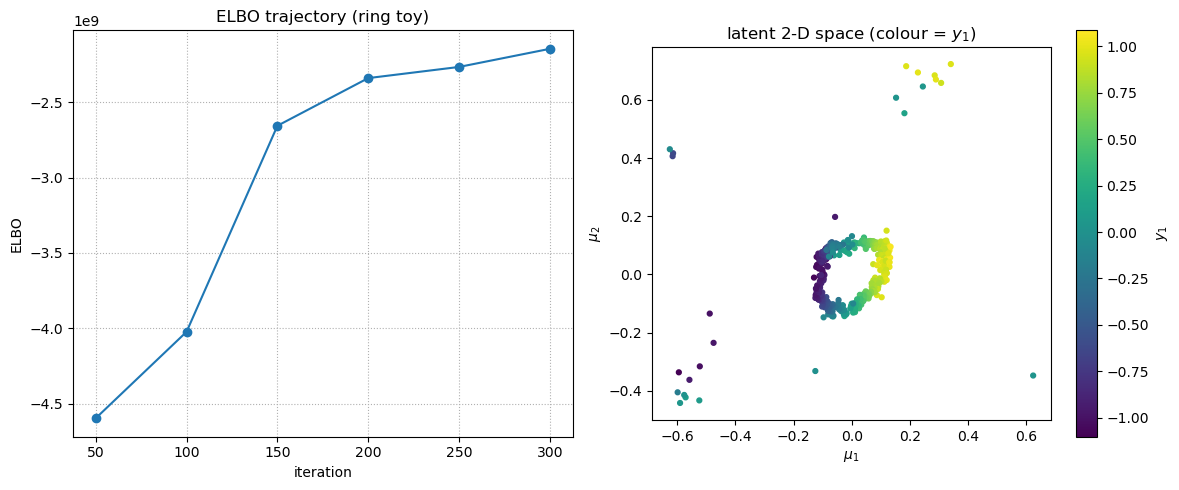

In [3]:
"Full SSVI. Toy data:noisy ring."
import math, torch, tqdm, matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
torch.set_default_dtype(torch.float64)
DEV = "cuda" if torch.cuda.is_available() else "cpu"

# ───────────── helpers ─────────────
def rho(t, t0=50., κ=0.9):            # Robbins–Monro rho_t
    return (t0 + t) ** (-κ)

# ──────────── ring data ────────────
N = 400
theta = torch.linspace(0, 2*math.pi, N+1, device=DEV)[:-1]
r = 1. + 0.05*torch.randn(N, device=DEV)
Y = torch.stack([r*torch.sin(theta), r*torch.cos(theta)], 1)     # (N,2)
D, Q = 2, 2                                              # latent dim

# ─────── kernel + inducing grid ─────
sqrtM = 8                            # 8 × 8 = 64 inducing points
grid = torch.linspace(-1.5, 1.5, sqrtM, device=DEV)
Z = torch.stack(torch.meshgrid(grid, grid, indexing='ij'), -1) \
        .reshape(-1, 2)                                   # (M,Q)
M = Z.size(0)

log_sf2      = torch.tensor(0.,  device=DEV, requires_grad=True) # log sigma^2_f
log_alpha    = torch.zeros(Q,    device=DEV, requires_grad=True) # log alpha_q (ARD kernel)
log_beta_inv = torch.tensor(-3., device=DEV, requires_grad=True) # gauss noise disp

def se_kernel(x, z):
    a = log_alpha.exp()                      # (Q,)
    diff2 = (x.unsqueeze(-2) - z)**2         # (...,M,Q)
    return log_sf2.exp()*torch.exp(-0.5*(diff2*a).sum(-1))

def Kmm():
    return se_kernel(Z, Z) + 1e-6*torch.eye(M, device=DEV)

def noise_var():                            # beta_inv
    return log_beta_inv.exp()

# ─── q(U) : factorised Gaussian (nat‑params) ───
with torch.no_grad():
    s2_u  = torch.full((D,M), 1e-2, device=DEV)   # initial cov
    h_u   = torch.zeros_like(s2_u) # natural parameter h
    lam_u = -0.5/s2_u              # natural parametel lambda 
for T in (h_u, lam_u): T.requires_grad_(False)

def sample_U():
    eps = torch.randn_like(h_u)
    var = -0.5/lam_u
    return h_u*var + eps*torch.sqrt(var) # U = mu + eps * sqrt(S)

# ─── q(x_n|U)  (diag Gaussians) ───
with torch.no_grad(): # init with circle
    mu_init = torch.stack([torch.sin(theta), torch.cos(theta)], 1)
mu_x    = mu_init.clone().detach().requires_grad_()
log_s2x = torch.full_like(mu_x, -2.0, requires_grad=True)   # s^2_x ~ 0.14
inner_opt = torch.optim.Adam([mu_x, log_s2x], lr=1e-2)

# ───────── psi‑statistics (Titsias 2010) ─────────
def psi_stats(mu, s2):
    sf2, a = log_sf2.exp(), log_alpha.exp()
    S = mu.size(0)

    psi0 = sf2.expand(S)

    d1 = a*s2 + 1.
    c1 = d1.rsqrt().prod(-1, keepdim=True)
    diff = mu.unsqueeze(1) - Z
    psi1 = sf2*c1*torch.exp(-0.5*((a*diff**2)/d1.unsqueeze(1)).sum(-1))

    d2 = a*s2 + 2.
    c2 = d2.rsqrt().prod(-1, keepdim=True)
    ZZ = Z.unsqueeze(1) - Z.unsqueeze(0)
    distMM = (a*ZZ**2).sum(-1)
    mid = (Z.unsqueeze(1)+Z.unsqueeze(0))/2.
    mu_c2 = (mu[:,None,None,:]-mid)**2
    expo = torch.exp(-0.25*distMM
                     -0.5*((a*mu_c2)/d2[:,None,None,:]).sum(-1))
    psi2 = sf2**2 * c2.unsqueeze(-1) * expo
    return psi0, psi1, psi2

# ───────── local ELBO (mini‑batch) ────────────
def local_terms(idxs, U, mu_loc, log_s2_loc):
    Km, Lm = Kmm(), torch.linalg.cholesky(Kmm())
    mu, s2 = mu_loc[idxs], log_s2_loc[idxs].exp()
    psi0, psi1, psi2 = psi_stats(mu, s2)

    A = torch.cholesky_solve(psi1.T, Lm).T        # (S,M)
    fmu = A @ U.T                                # (S,D)
    tr = torch.cholesky_solve(psi2, Lm)\
            .diagonal(0,-2,-1).sum(-1)          # (S,)
    sigma2 = (noise_var() + psi0 - tr).clamp_min(1e-8)

    log_like = (-0.5*math.log(2*math.pi)
                -0.5*sigma2.log()[:,None]
                -0.5*(Y[idxs]-fmu)**2/sigma2[:,None]).sum(-1)
    # isotropic weak prior N(0,5I)
    kl_x = 0.5*((s2+mu**2)/5 - s2.log() + math.log(5) - 1).sum(-1)
    return (log_like - kl_x).mean(), (psi1, psi2, sigma2)

# ───────── KL[q(U)||p(U)] ─────────────────────
def KL_U():
    Km, Lm = Kmm(), torch.linalg.cholesky(Kmm())
    Kin_diag = torch.cholesky_solve(torch.eye(M,device=DEV), Lm).diag()
    var_u, mean_u = -0.5/lam_u, h_u*(-0.5/lam_u)
    tr=(Kin_diag*var_u).sum(); quad=(Kin_diag*mean_u**2).sum()
    logdet_p=D*2*Lm.diagonal().log().sum() 
    logdet_q=var_u.log().sum()
    return 0.5*(tr+quad-D*M+logdet_p-logdet_q)

@torch.no_grad()
def full_ELBO():
    return local_terms(torch.arange(N,device=DEV), sample_U(),
                       mu_x, log_s2x)[0] - KL_U()

# ───────── optimisation loop ────────────────
T_TOTAL, BATCH, INNER = 300, 128, 6
hyp_opt = torch.optim.Adam([log_sf2, log_alpha, log_beta_inv], lr=2e-4)
WARM = 50

eh, it = [], []
bar = tqdm.trange(1, T_TOTAL+1, ncols=120)
for t in bar:
    idx = torch.randint(0,N,(BATCH,),device=DEV)

    # ----- E‑step -----
    for _ in range(INNER):
        inner_opt.zero_grad(set_to_none=True)
        le,_ = local_terms(idx, sample_U().detach(), mu_x, log_s2x)
        (-le).backward(); inner_opt.step()
        mu_x.detach_().requires_grad_(); log_s2x.detach_().requires_grad_()

    # ----- M‑step : hyper‑params -----
    U_s, rho_variable = sample_U(), rho(t)
    le,(psi1,_,sigma2) = local_terms(idx,U_s,mu_x,log_s2x)
    if t>=WARM:
        hyp_opt.zero_grad(set_to_none=True)
        (-(le-KL_U())).backward(); hyp_opt.step()

    # ----- M‑step : nat‑params q(U) -----
    with torch.no_grad():
        Lm = torch.linalg.cholesky(Kmm())
        A  = torch.cholesky_solve(psi1.detach().T, Lm).T
        r_n = ((Y[idx]/sigma2[:,None])[:,:,None])*A[:,None,:]
        q_n = -0.5*(A**2)/sigma2[:,None]
        r_t = r_n.sum(0); q_t=q_n.sum(0).unsqueeze(0).expand(D,-1)
        deltaU = U_s - h_u*(-0.5/lam_u)
        r_t += 2*q_t*deltaU
        scale=N/BATCH
        lambda0 = -0.5*torch.cholesky_solve(torch.eye(M,device=DEV),Lm).diag()
        h_u += rho_variable*(scale*r_t - h_u)
        lam_u += rho_variable*(lambda0.unsqueeze(0)+scale*q_t - lam_u)
        lam_u.clamp_(max=-1e-8)

    if t%50==0:
        e=full_ELBO().item(); eh.append(e); it.append(t)
        bar.set_postfix({"ELBO":f"{e:.2e}"})

# ─────────── visuals ────────────
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(it,eh,"-o"); ax[0].grid(ls=":")
ax[0].set_xlabel("iteration"); ax[0].set_ylabel("ELBO")
ax[0].set_title("ELBO trajectory (ring toy)")

mu = mu_x.detach().cpu()
sc=ax[1].scatter(mu[:,0],mu[:,1],c=Y[:,0].cpu(),cmap="viridis",s=12)
ax[1].set_xlabel(r"$\mu_1$"); ax[1].set_ylabel(r"$\mu_2$")
ax[1].set_aspect("equal"); ax[1].set_title("latent 2‑D space (colour = $y_1$)")
plt.colorbar(sc,ax=ax[1],label="$y_1$")
plt.show()
